In [ ]:
import cv2 as cv
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
from google.colab import files





## Image Pre-Processing

- Section 1, No Pre-processing done to the image, we are reading in the image and creating a feature map directly to the image.
- Section 2, basic processing with sobel operations, gradients, thresholding, histogram equalization
- Section 3, Using Morphological Operators, smoothing/blurring

- **We will notice that the images may have some white noise/bad edges that may need to be cropped/processed out.**


In [ ]:
uploaded = files.upload()



#Firstly load images in with openCV, convert BGR2RGB
# Resize to 224x224 pixels for VGG-16
# Apply Image Processing Techniques.
# Convert Image to Tensor for pytorch functions

#Normalize the images after converting to tensor using Pytorch transforms
#Normalize an image from a range of values between 0-255 to the pytorch range, 0-1
#pytorch tensors have shape [C,H,W]
#Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images


#Returns a normalized pytorch tensor
def load_basic_img(image):
    #original shape ~ (496, 512, 3)
    image = cv.resize(image, (224, 224)) #resize for VGG-16, 224x224 is common.
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) #convert OpenCV default BGR to RGB
    #convert to pytorch tensor and normalize
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
                                ])
    img_trs = transform(image)
    return img_trs

def load_processed_img(image):
    pass


#one time function, creates set of images we want to test
#I want to read in all the images in the OCT folder
def create_image_set():
    img_list = [] #create image list
    path = glob.glob("/content/*.jpeg") #path iterable to each testing file
    for i in path:
        image = cv.imread(i) #read in files
        img_list.append(image) #append to image list
    return img_list



Saving CNV-103044-10.jpeg to CNV-103044-10.jpeg
Saving DME-1274315-2.jpeg to DME-1274315-2.jpeg
Saving DRUSEN-1173253-1.jpeg to DRUSEN-1173253-1.jpeg
Saving NORMAL-1038998-1.jpeg to NORMAL-1038998-1.jpeg


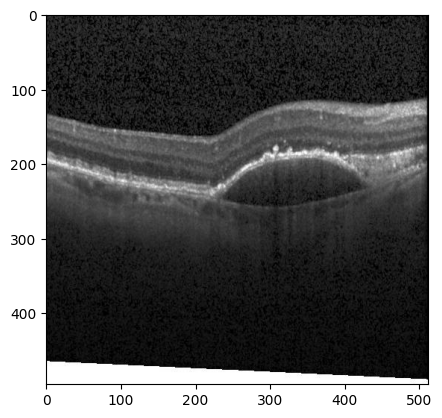

In [ ]:
img_list_test = create_image_set()
plt.imshow(img_list_test[0])

## Loading Images

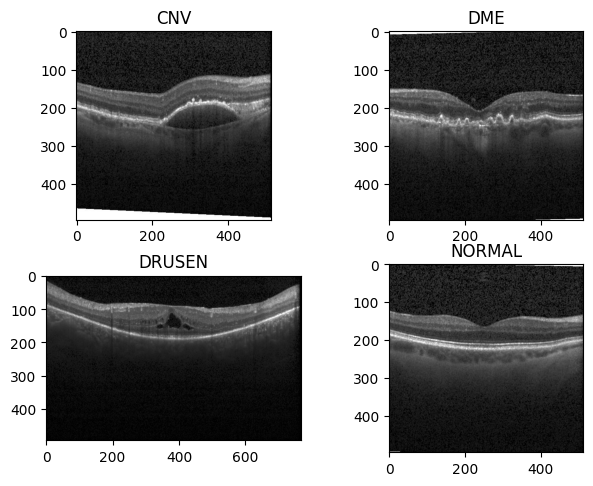

In [ ]:
#we want a feature map of Conv Layer 3 of VGG-16 which has 256 filters.

#load the models and the image sets we want to work with
#image set 1 is unprocessed
#image set 2 is processed.

img_list = create_image_set() #create a list of images
fig, axes = plt.subplots(2,2) #create visual layout for images, 2x2 grid
fig.tight_layout()          #layout images neatly


titles = ["CNV", "DME", "DRUSEN", "NORMAL"] #title each subplot, according to each of the optical conditions
ind = 0
for ax,img in zip(axes.flat, img_list):
    ax.imshow(img) #show each image
    ax.set_title(titles[ind])
    ind+=1
plt.show()




# basic_img_list = []
# for img, in img_list:
#     load_basic_img(img)
#     basic_img_list = basic_img





## Testing Processing Methods. Preparing Images for Feature Extraction.

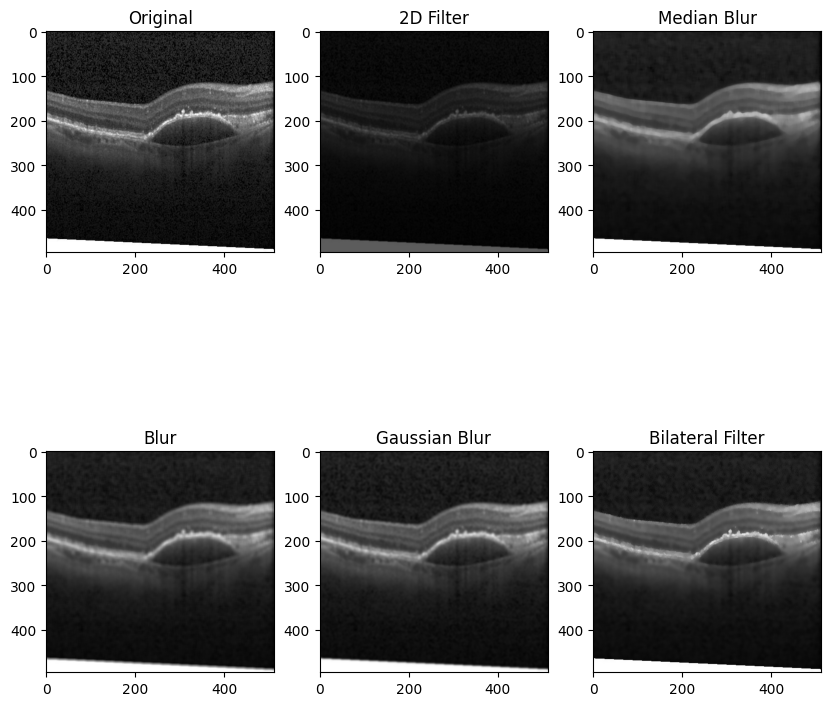

In [ ]:

#apply basic functions to the images,
#we will attempt removing the noise, smoothing, morphological operators,

#As the speckle noise can be modelled as multiplicative noise,
#the logarithmic operation is used to transform speckle noise into the classical additive white noise
#et. "Adaptive-weighted bilateral filtering and other pre-processing techniques for optical coherence tomography"

#The next step is layer segmentation(Watershed Algorithm, which will be used in the disease detection process and for measuring layer thickness

image1 = img_list[0]
image2 = img_list[1]
image3 = img_list[2]
image4 = img_list[3]


#applying a 2dfilter smoothing, and testing OpenCV default blur
kernel = np.ones(shape = (3,3), dtype = np.float32)/25
smoothed = cv.filter2D(image1,-1,kernel) #same desired depth, 3x3 kernel
#applying median blur, and default blur for comparison, blurring is supposed to remove speckle noise
med_blur = cv.medianBlur(image1, 11) #kernel size for median blur is constant odd number
def_blur = cv.blur(image1, ksize = (8,8))
#Applying a Gaussian blur
gau_blur = cv.GaussianBlur(image1, ksize = (11,11),sigmaX = 0)
#Applying a bilateral filter
filtered = cv.bilateralFilter(image1, d=10, sigmaColor = 100, sigmaSpace = 100)


results = [image1, smoothed, med_blur, def_blur, gau_blur, filtered]
titles = ["Original", "2D Filter", "Median Blur", "Blur", "Gaussian Blur", "Bilateral Filter"]
ind = 0
#display results
fig, axes = plt.subplots(nrows = 2,ncols = 3, figsize = (10,10))
for ax,img in zip(axes.flat, results):
    ax.imshow(img) #show each image
    ax.set_title(titles[ind])
    ind+=1
plt.show()


>**Conclusion: 2Dfilter Removed the Speckle noise but darkened the overall image,
Median Blur appears to have smoothed the edges and speckles
The other Three blurring/smoothing techniques resulted similarly,
bilateral filtering achieving the best edges with some smoothing of the speckles**

In [ ]:
#Morphological operations and thresholding on the images
#testing on image1 still
#closed = cv.morphologyEx(image1, cv.MORPH_CLOSE, kernel)



smoothed_gray = cv.cvtColor(smoothed, cv.COLOR_BGR2GRAY)
#THE FOLLOWING PROVED INEFFECTIVE
#isolate horizontal lines using sobel y
sobely = cv.Sobel(image1, cv.CV_64F, 0, 1, ksize = 5)
#plt.imshow(sobely)

#lets try to histogram equalization on the smoothed image
hist_eq = cv.equalizeHist(smoothed_gray)
#plt.imshow(hist_eq, 'gray')

#lets attempt a threshold on the smoothing image
image1_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
threshed = cv.adaptiveThreshold(image1_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 8)
#plt.imshow(threshed, cmap = 'gray')




## Using Pytorch to extract VGG-16 Conv layers for feature map, UNPROCESSED IMAGE

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 160MB/s]


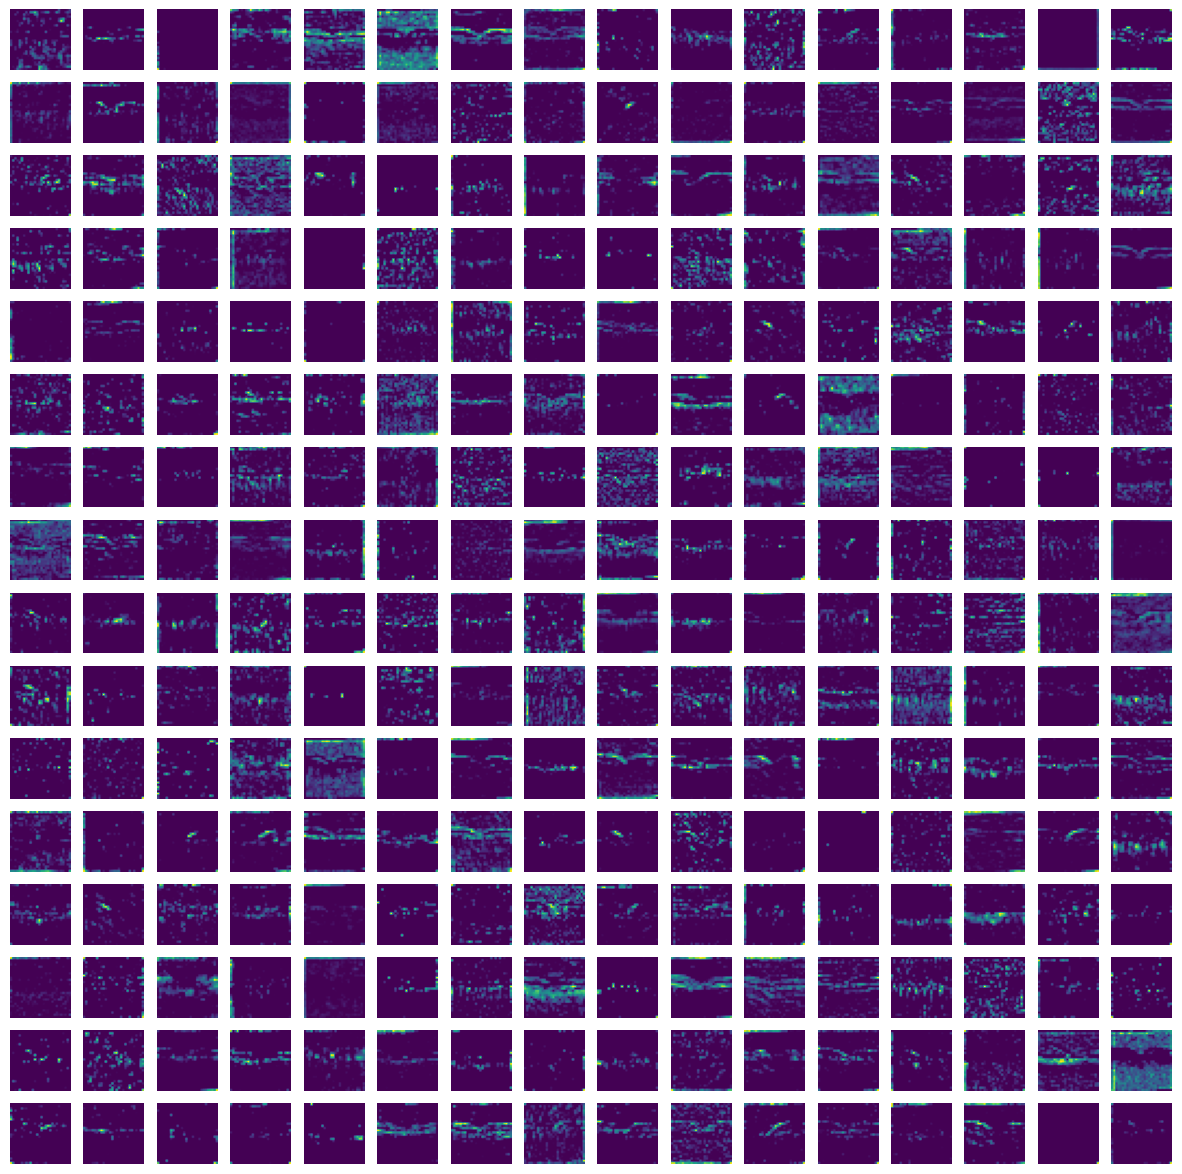

In [ ]:
model = models.vgg16(weights=True).features  # Only the convolutional layers
model.eval()  # Set the model to evaluation mode

# 3. Hook function to capture the feature maps from intermediate layers
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Attach hooks to the layers you want to visualize
layer_name = 'conv3'  # Choose a layer to visualize
model[16].register_forward_hook(get_activation(layer_name))  # Change index for different layers

# 4. Feed the image through the model to get feature maps
image_test = img_list[1] #Lets test the first image from the image list
image_tensor = load_basic_img(image_test)

with torch.no_grad(): #says we dont want to update the weights since we are using the pre-trained portion, gradient calculation off.
    output = model(image_tensor)  # Run the image through the model

# 5. Visualize the feature maps
def visualize_feature_maps(activation, layer_name):
    # Get the feature maps from the layer
    feature_maps = activation[layer_name].squeeze().cpu().numpy()

    # Plot feature maps
    num_feature_maps = feature_maps.shape[0]
    size = int(np.ceil(np.sqrt(num_feature_maps)))

    fig, axes = plt.subplots(size, size, figsize=(15, 15))
    for i in range(num_feature_maps):
        ax = axes[i // size, i % size]
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
    plt.show()

# Call the visualization function
visualize_feature_maps(activation, layer_name)